# GreenBuildings 2: Imputing Missing Values With Scikit-Learn
------


## Introduction <a class="anchor" id="first-bullet"></a>
-------------
	
This is the second post in a series of blog posts about building a predictive model of green house gas emissions of buildings in NYC. In my first post I covered how to do

- Exploratory data analysis
- Identify and remove outliers

In this current blog post I will cover the very important topic of 

- Imputing missing values

Specifically I will cover [imputations techniques](https://scikit-learn.org/stable/modules/impute.html) in Scikit-Learn.

## Connecting To BigQuery

Now since I will be working on this project over a few days I write this data to table so I won't have to constantly load and clean it again and again.  Since I'm using the [Google Cloud Platform](https://cloud.google.com/), I'll create a [BigQuery](https://cloud.google.com/bigquery).  This requires that I have credentials.  I used the [google-auth-oauthlib](https://pypi.org/project/google-auth-oauthlib/) package and followed the instructions [here](https://cloud.google.com/bigquery/docs/authentication/end-user-installed) to create a credentials json file and connected to BigQuery using [pandas_bgq](https://pandas-gbq.readthedocs.io/en/latest/):

In [18]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from google.oauth2 import service_account

credentials = service_account.Credentials\
                             .from_service_account_file('./derby.json')

from google.cloud import bigquery

client = bigquery.Client(project     = 'advance-sonar-232016',
                         credentials = credentials)



## Analyzing Distributions & Correlations

Now lets focus our energy on imputing missing values in our dataset. Let's first 

In [12]:
result = client.query("""
SELECT 
    column_name
FROM 
    db_gb.INFORMATION_SCHEMA.COLUMNS
WHERE 
    table_name = 'no_outlier_data'
""")

In [16]:
for row in result.result():
    print(row[0])

Energy_Star
Site_EUI
NGI
EI
WI
GHGI
OPSFT
Age
Residential


Downloading: 100%|██████████| 2/2 [00:00<00:00, 18.21rows/s]


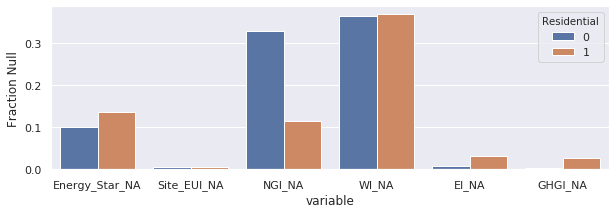

In [19]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS NGI_NA,
   SUM(CASE WHEN WI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS WI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) / COUNT(*) AS GHGI_NA,
FROM 
    db_gb.no_outlier_data 
GROUP BY 
    Residential
"""

frac_nulls_df = pandas_gbq.read_gbq(query)

frac_nulls_df2 = frac_nulls_df.melt(id_vars='Residential')\
                              .rename(columns={"value":"Fraction Null"})

plt.figure(figsize=(10,3))
sns.barplot(data=frac_nulls_df2,
            x='variable',
            y='Fraction Null',
            hue='Residential')


In [80]:
df = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   Site_EUI,
   NGI,
   EI,
   WI,
   GHGI,
   Age,
   OPSFT,
   Residential,
FROM
    db_gb.no_outlier_data
""")

Downloading: 100%|██████████| 9834/9834 [00:01<00:00, 7085.22rows/s]


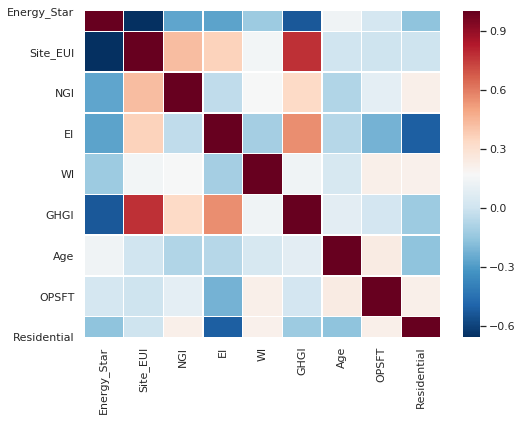

In [82]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
Xs      = scaler1.fit_transform(df)
xs_df   = pd.DataFrame(Xs, columns=df.columns)

fig, ax = plt.subplots(figsize=(8,6))  
sns.color_palette("BuGn_r",)
sns.heatmap(xs_df.corr(),
            linewidths=.5,
            cmap="RdBu_r")

/home/mdh266/.conda/envs/greenbuildings/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


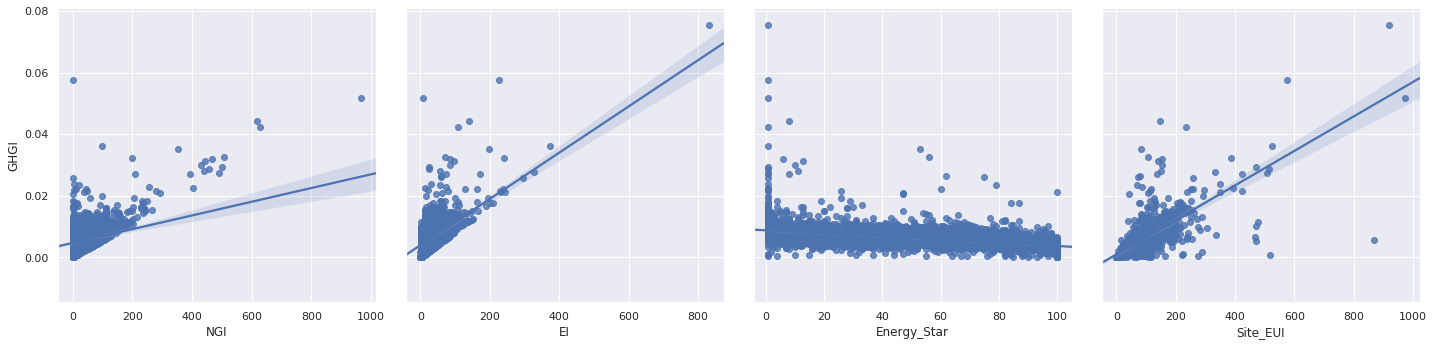

In [279]:
sns.pairplot(df, 
             x_vars=['NGI','EI','Energy_Star','Site_EUI'], 
             y_vars='GHGI', 
             kind = 'reg',
             size=5, 
             dropna=True)

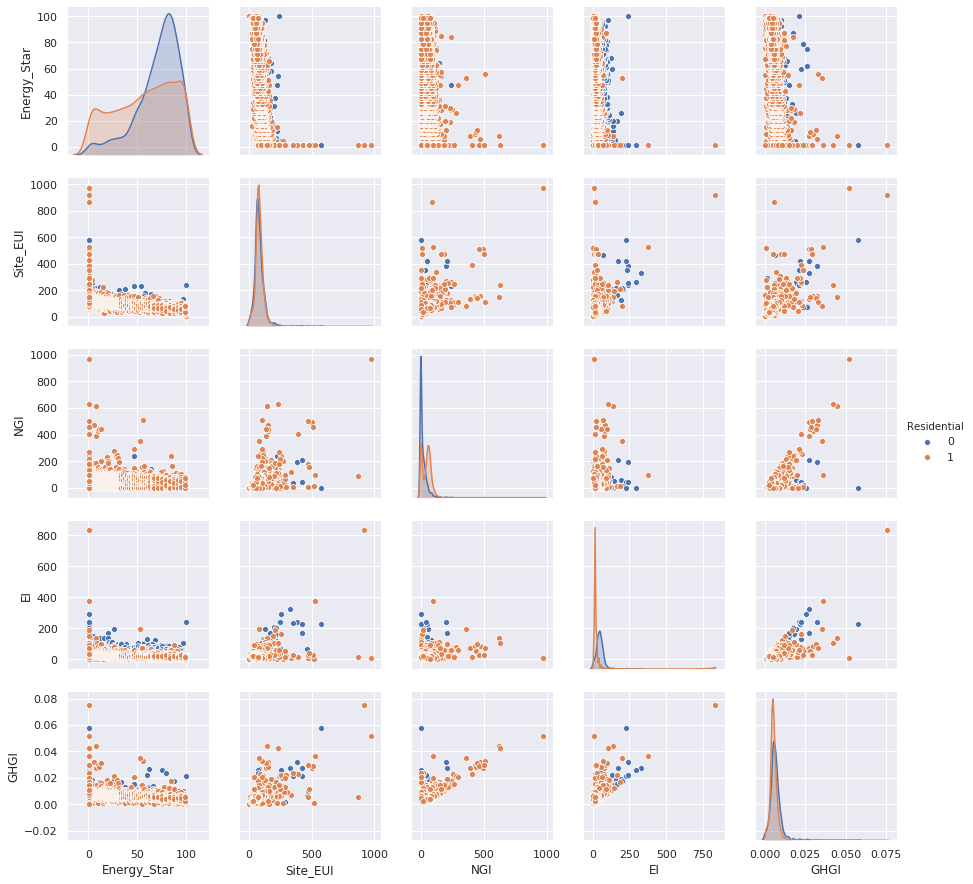

In [46]:
sns.pairplot(df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

Downloading: 100%|██████████| 9834/9834 [00:00<00:00, 11650.10rows/s]


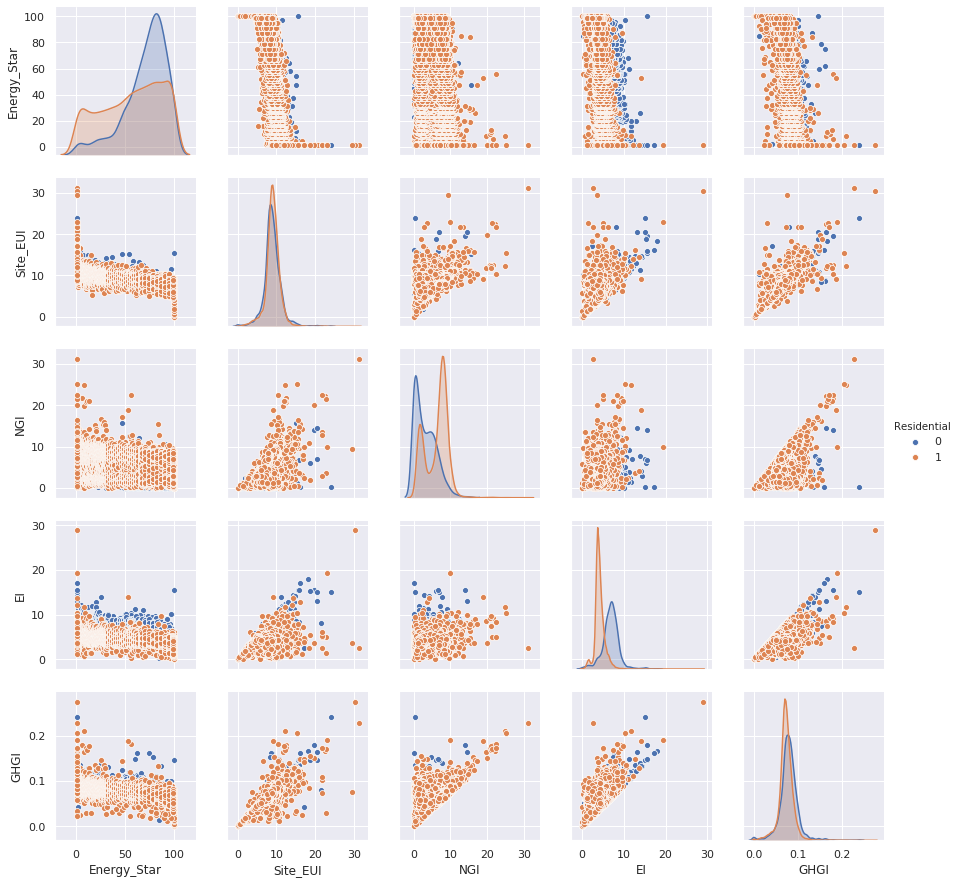

In [60]:
df_sqrt = pandas_gbq.read_gbq("""
SELECT
   Energy_Star,
   SQRT(Site_EUI) AS Site_EUI,
   SQRT(NGI)      AS NGI,
   SQRT(EI)       AS EI,
   SQRT(GHGI)     AS GHGI,
   Residential,
FROM db_gb.no_outlier_data """)

sns.pairplot(df_sqrt,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

Downloading: 100%|██████████| 2/2 [00:00<00:00, 17.20rows/s]


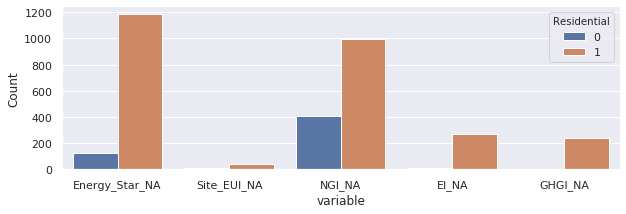

In [48]:
query = """
SELECT
   Residential,
   SUM(CASE WHEN Energy_Star IS NULL THEN 1 ELSE 0 END)  AS Energy_Star_NA,
   SUM(CASE WHEN Site_EUI IS NULL THEN 1 ELSE 0 END)  AS Site_EUI_NA,
   SUM(CASE WHEN NGI IS NULL THEN 1 ELSE 0 END)  AS NGI_NA,
   SUM(CASE WHEN EI IS NULL THEN 1 ELSE 0 END)  AS EI_NA,
   SUM(CASE WHEN GHGI IS NULL THEN 1 ELSE 0 END) AS GHGI_NA,
FROM db_gb.raw_data 
GROUP BY Residential
"""

num_nulls_df  = pandas_gbq.read_gbq(query)
num_nulls_df2 = num_nulls_df.melt(id_vars='Residential')\
                            .rename(columns={"value":"Count"})

plt.figure(figsize=(10,3))
sns.barplot(data=num_nulls_df2,
            x='variable',
            y='Count',
            hue='Residential')


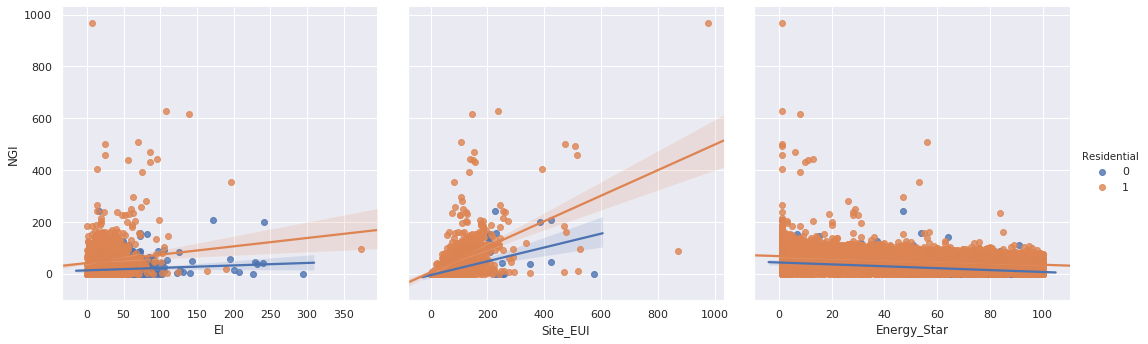

In [85]:
sns.pairplot(df, 
             x_vars=['EI','Site_EUI','Energy_Star'], 
             y_vars='NGI', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

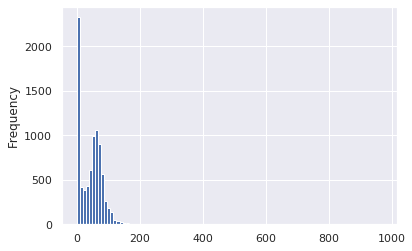

In [86]:
df["NGI"].plot(kind="hist",bins=100)

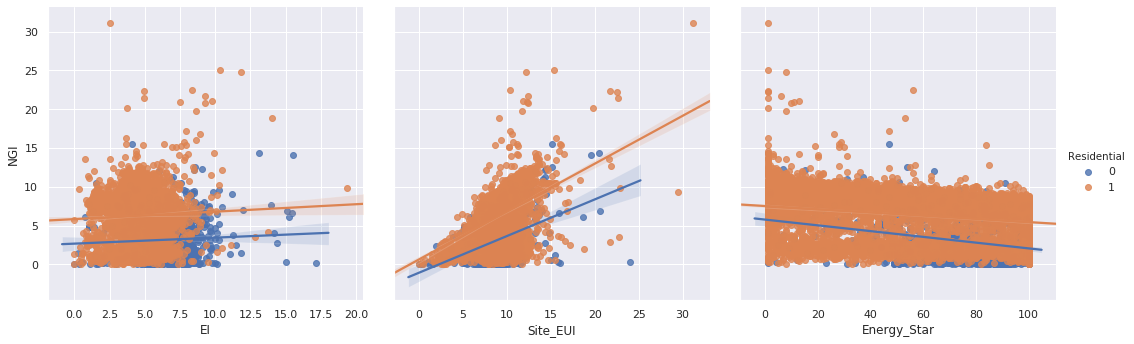

In [87]:
sns.pairplot(df_sqrt, 
             x_vars=['EI','Site_EUI','Energy_Star'], 
             y_vars='NGI', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

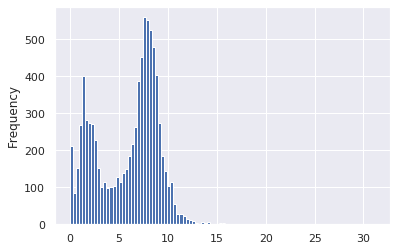

In [88]:
df_sqrt["NGI"].plot(kind="hist",bins=100)

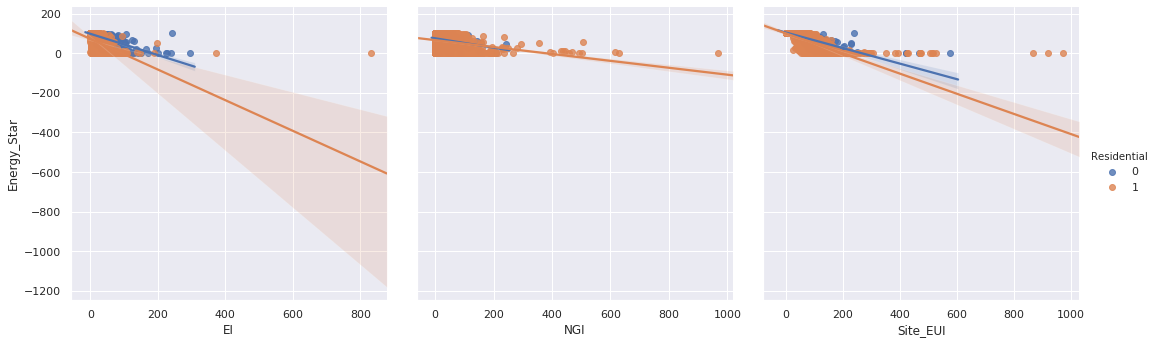

In [112]:
sns.pairplot(df, 
             x_vars=['EI','NGI','Site_EUI'], 
             y_vars='Energy_Star', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

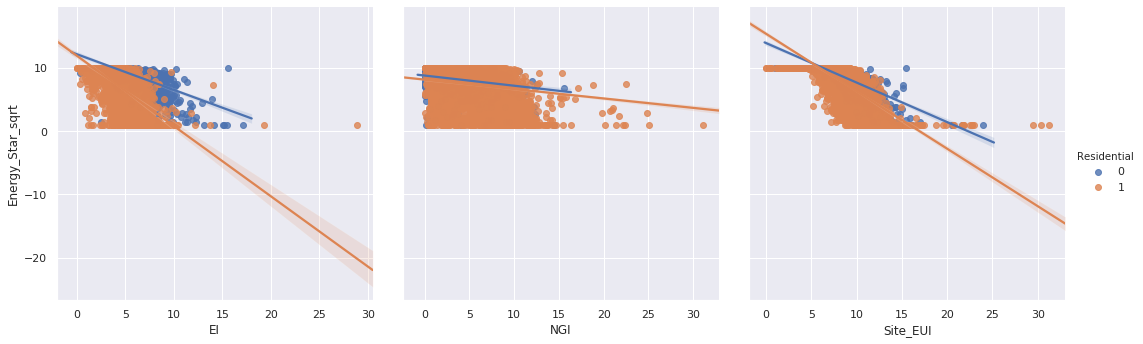

In [116]:
sns.pairplot(df_sqrt, 
             x_vars=['EI','NGI','Site_EUI'], 
             y_vars='Energy_Star_sqrt', 
             hue='Residential',
             kind = 'reg',
             size=5, 
             dropna=True)

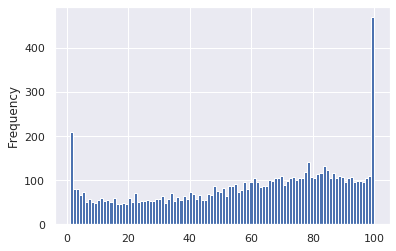

In [123]:
df["Energy_Star"].plot(kind="hist",bins=100)

## Imputing Missing Values With Scikit-Learn

In [259]:
df2 = pandas_gbq.read_gbq("""
SELECT
   SQRT(Energy_Star) AS Energy_Star,
   SQRT(Site_EUI)    AS Site_EUI,
   SQRT(NGI)         AS NGI,
   SQRT(EI)          AS EI,
   SQRT(GHGI)        AS GHGI,
   Residential,
FROM 
    db_gb.no_outlier_data
WHERE 
    GHGI IS NOT NULL
AND EI IS NOT NULL
AND Site_EUI IS NOT NULL
""")

Downloading: 100%|██████████| 9542/9542 [00:00<00:00, 13315.92rows/s]


In [260]:
df2.shape[0]

9542

In [261]:
from sklearn.model_selection import train_test_split, cross_val_score

X_real = df2.drop(['GHGI'], axis=1)
Y_real = df2['GHGI']

X_train, X_test, Y_train, Y_test = train_test_split(X_real,Y_real, random_state=32)

In [262]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline     import make_pipeline, Pipeline
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute       import SimpleImputer, IterativeImputer
from sklearn.neighbors    import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import r2_score

In [263]:
median_pipe = make_pipeline(SimpleImputer(strategy='median'),
                            StandardScaler(),
                            LinearRegression())
 
np.mean(cross_val_score(median_pipe, X_train, Y_train, cv=5))

0.7725604341677739

In [264]:
median_pipe.fit(X_train, Y_train)
Y_pred = median_pipe.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7367136786698119


In [265]:
mean_pipe = make_pipeline(SimpleImputer(strategy='mean'),
                          StandardScaler(),
                          LinearRegression())

np.mean(cross_val_score(mean_pipe, X_train, Y_train, cv=5))

0.7743467899266664

In [266]:
mean_pipe.fit(X_train, Y_train)
Y_pred = mean_pipe.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7380299911016297


In [267]:
knn_pipe = Pipeline([("scaler",  StandardScaler()),
                     ("imputer", IterativeImputer(estimator=KNeighborsRegressor())),
                     ("reg",     LinearRegression())])

In [269]:
params = {"imputer__estimator__n_neighbors": [1,5,10,15,20],
          "imputer__estimator__weights":     ["uniform","distance"]}

grid   = GridSearchCV(estimator   = knn_pipe,
                      param_grid  = params,
                      scoring     = "r2",
                      cv          = 5,
                      n_jobs      =-1)

In [270]:
grid.fit(X_train, Y_train)
knn_imputer = grid.best_estimator_

/home/mdh266/.conda/envs/greenbuildings/lib/python3.7/site-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [271]:
grid.best_score_

0.776320101469847

In [272]:
Y_pred = knn_imputer.predict(X_test)

# Explained variance score: 
print("Variance score: {}".format(r2_score(Y_test, Y_pred)))

Variance score: 0.7409273425366196


In [273]:
transformer = knn_imputer[0]
transformer 

StandardScaler(copy=True, with_mean=True, with_std=True)

In [274]:
imputer = knn_imputer[1]
imputer

IterativeImputer(add_indicator=False,
                 estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                               metric='minkowski',
                                               metric_params=None, n_jobs=None,
                                               n_neighbors=10, p=2,
                                               weights='distance'),
                 imputation_order='ascending', initial_strategy='mean',
                 max_iter=10, max_value=None, min_value=None,
                 missing_values=nan, n_nearest_features=None, random_state=None,
                 sample_posterior=False, skip_complete=False, tol=0.001,
                 verbose=0)

In [275]:
X_fixed = transformer.inverse_transform(
                imputer.transform(
                    transformer.transform(X_real)))

In [276]:
X_df = pd.DataFrame(X_fixed, columns=X_real.columns)

In [280]:
X_sqrt_df = pd.concat([X_df.reset_index().drop("index",axis=1), 
                       Y_real.to_frame().drop("index",axis=1).reset_index()], 
                     axis=1)

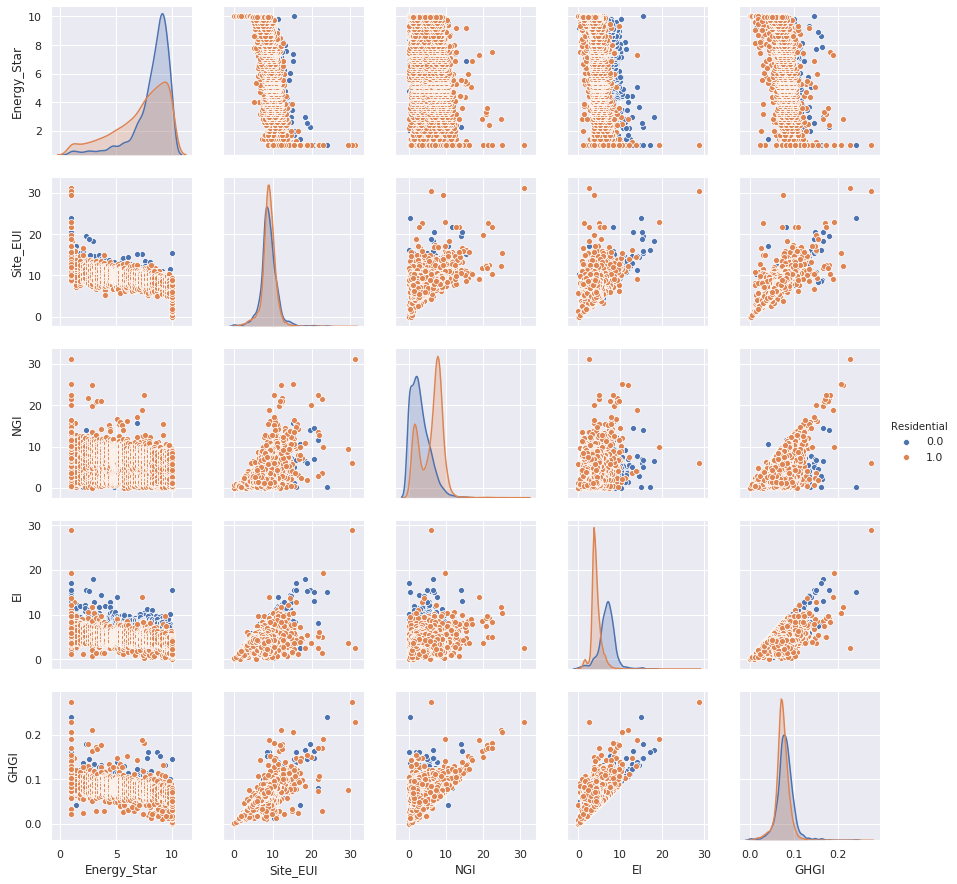

In [281]:
sns.pairplot(X_sqrt_df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

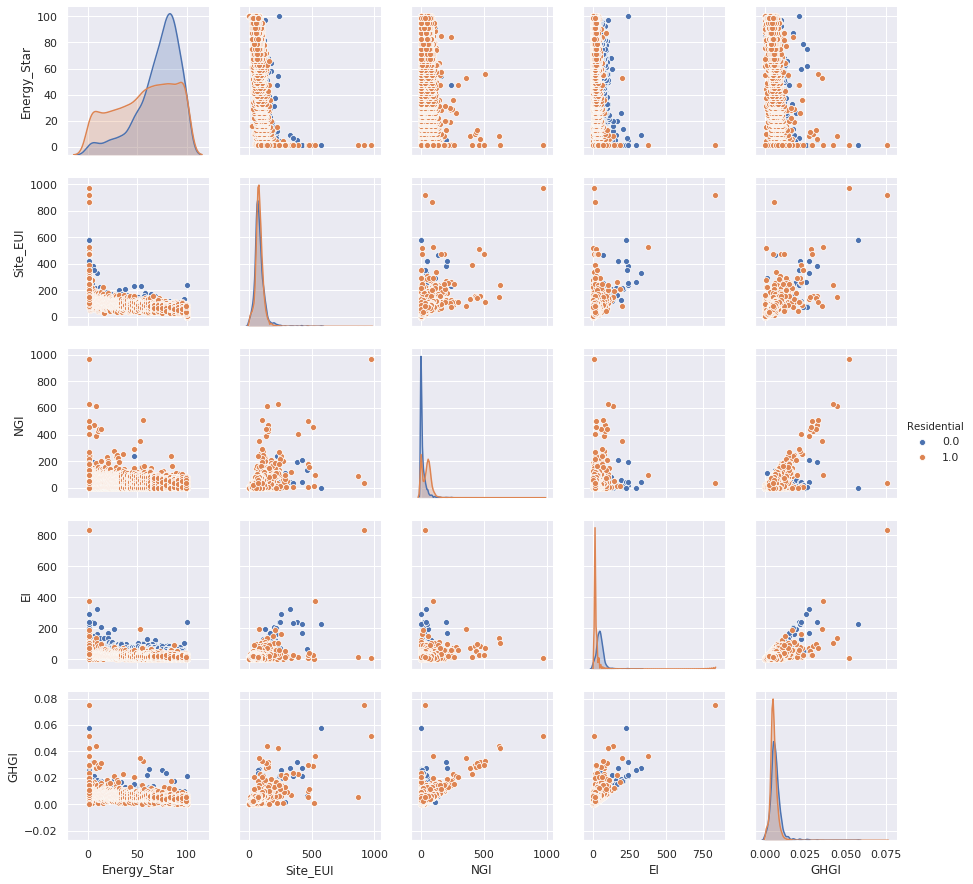

In [284]:
X_fin_df = X_sqrt_df.apply(lambda x: x*x)

sns.pairplot(X_fin_df,
             vars=["Energy_Star","Site_EUI","NGI","EI","GHGI"],
             hue='Residential')

In [1]:
pandas_gbq.to_gbq(X_fin_df,"db_gb.data_clean")

--------------
## Next Steps
---------------